In [52]:
!python -m spacy download en_core_web_sm
import dill
import json

import string
import spacy
import hunspell

import numpy as np
import scipy

import seaborn as sns

from scipy.sparse import csr_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.0 MB/s  0:00:00a 0:00:0136m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [53]:
spc = spacy.load('en_core_web_sm')
hsl = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

In [54]:
processed_data_path = '../data/processed/'

corpus_fn = processed_data_path + 'corpus.pkl'
tes_fn = processed_data_path + 'tes.pkl'
lexicon_fn = processed_data_path + 'lexicon.json'
dirtes_fn = processed_data_path + 'dirtes.json'
colex_fn = processed_data_path + 'colex.pkl'
lgclx_fn = processed_data_path + 'lgclx.pkl'

In [55]:
SELECTED_POS = {'NOUN', 'VERB', 'ADJ'}

corpus = dill.load(open(corpus_fn, 'rb'))
tes = dill.load(open(tes_fn, 'rb'))

In [56]:
### SELECTING & CLEANING LEMMAS

def clean(text):
    text = text.lower()
    text = text.encode("ascii", "ignore").decode("ascii")
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text
    
def select(entry):
    if len(entry) <= 1:
        #print("remove:", entry)
        return None

    # cleaning
    entry = clean(entry)

    if not entry.isalpha():
        return None

    # for now: just remove typos, revisit later
    if not hsl.spell(entry):
        return None

    # for now: remove other pos, revisit later
    try:   
        if spc(entry)[0].pos_ not in SELECTED_POS:
            print("wrong pos:", lemma)
            return None
    except:
        return None
        
    return entry

In [62]:
### EXTRACTING LEXICON

def extract_language_lexicon(langcorp):    
    lexicon = set()
    
    for document in langcorp:
        for sentence in langcorp[document]:
            for word in langcorp[document][sentence]['spc']:
                if word['pos'] in SELECTED_POS:
                    lexicon.add(select(word['lemma']))

    return sorted(lexicon - {None})

def extract_lexicon(corpus):    
    return sorted(set(sum([extract_language_lexicon(corpus[lang]) for lang in corpus], [])))

In [58]:
### EXTRACTING DIRECT TES
# add counts ?

def extract_language_dirtes(langtes, min_stem_freq=1):    
    dirtes = dict()

    for te in langtes:
        lemma = select(te)
        if lemma:
            eqs = langtes[te]
            terms = set(sum([list(map(str, eqs[e].keys())) for e in eqs if sum(eqs[e].values()) >= min_stem_freq], []))
            
            if lemma in dirtes:
                dirtes[lemma] = sorted(set(dirtes[lemma]) | terms)
            else:
                dirtes[lemma] = sorted(terms)
                
    return dirtes

def extract_dirtes(tes, min_stem_freq=1):
    return {lang: extract_language_dirtes(tes[lang], min_stem_freq) for lang in tes}

In [59]:
### COMPUTING COLEXIFICATION

def unique_targets(dt):
    return sorted({target for k in dt for target in dt[k]})

def compute_language_colex(lexicon, langdirtes):
    dt = langdirtes
    targets = unique_targets(dt)
    #print(len(targets))
    
    row = []
    col = []
    data = []
    
    for lemma in dt:
        for target in dt[lemma]:
            if lemma not in lexicon:
                #print("NOT IN LEXICON:", lemma)
                continue
            i = lexicon.index(lemma)
            j = targets.index(target)
            row.append(i)
            col.append(j)
            data.append(1)
    
    mx = csr_matrix((data, (row, col)), shape=(len(lexicon), len(targets)))
    
    colex = mx * mx.transpose()
    colex = (colex / colex.max()).ceil()
    colex.setdiag(0)
    #print(colex.max())
    
    return colex

def compute_colex(lexicon, dirtes):
    return np.sum([compute_language_colex(lexicon, dirtes[lang]) for lang in dirtes])

def print_colex(lexicon, colex):
    rows = sorted(set(colex.nonzero()[0]))
    for i in rows:
        cols = colex.getrow(i).nonzero()[1]
        #print(i, cols)
        if len(cols) > 1:
            print(lexicon[i], ":", [(lexicon[j], int(colex[i,j])) for j in cols])

def filter_colex(colex, min_clx_count=None, max_clx_size=None):
    clx = colex.copy()
    
    # filter minimum colex count (min nlangs that colex)
    if min_clx_count:
        clx.data[clx.data < min_clx_count] = 0
        clx.eliminate_zeros()

    # filter maximum colex array size (max nterms in a row)
    if max_clx_size:
        larger = [i for i in set(clx.nonzero()[0]) if len(clx.getrow(i).nonzero()[1]) > max_clx_size]
        tmp = clx.toarray()
        tmp[larger, :] = 0
        tmp[:, larger] = 0

        clx = csr_matrix(tmp)
        clx.eliminate_zeros()
        
    return clx

In [63]:
### LEXICON

lexicon = extract_lexicon(corpus)
json.dump(lexicon, open(lexicon_fn, 'w'))
#lexicon = json.load(open(lexicon_fn, 'r'))
len(lexicon)

6130

In [64]:
### DIRECT TES DICTIONARIES

MIN_STEM_FREQ = 2
# visualize in func of min stem freq

dirtes = extract_dirtes(tes, MIN_STEM_FREQ)
json.dump(dirtes, open(dirtes_fn, 'w'))
#dirtes = json.load(open(dirtes_fn, 'r'))

AttributeError: 'dict' object has no attribute 'lower'

In [ ]:
### COMPUTING COLEXIFICATION MATRIX

colex = compute_colex(lexicon, dirtes)
dill.dump(colex, open(colex_fn, 'wb'))
#colex = dill.load(open(colex_fn, 'rb'))

lgclx = {lang: compute_language_colex(lexicon, dirtes[lang]) for lang in dirtes}
dill.dump(lgclx, open(lgclx_fn, 'wb'))
#lgclx = dill.load(open(lgclx_fn, 'rb'))

In [ ]:
print_colex(lexicon, colex)

[23652, 3832, 1686, 952, 620, 438, 314, 224, 182, 146, 126, 108, 94, 68]


<Axes: >

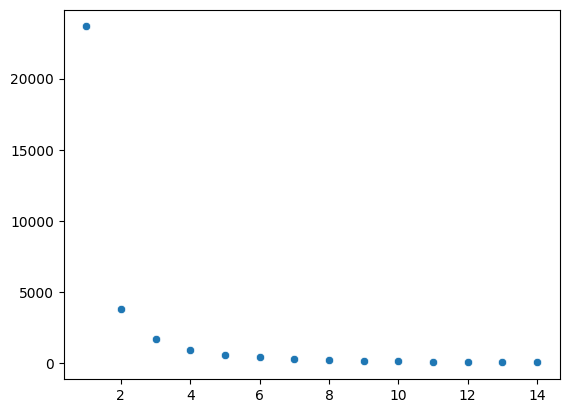

In [15]:
### PLOT DECREASE OF COLEXES AS WE INCREASE MIN COLEX COUNT

rng = range(1,15)
nb_colexed = [filter_colex(colex, i).nnz for i in rng]
print(nb_colexed)
sns.scatterplot(x=rng, y=nb_colexed)
# plot y on log scale

<Axes: >

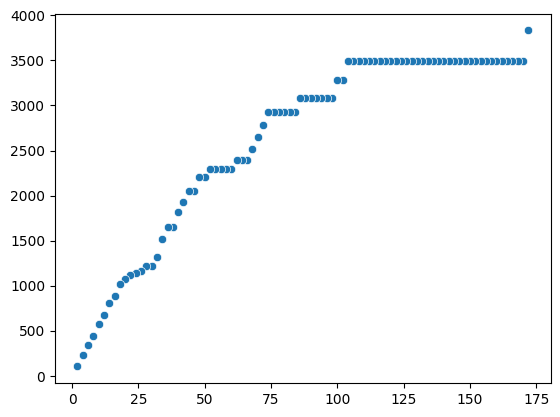

In [17]:
### PLOT N OF ITEMS IN FUNCTION OF MAX COLEX SIZE

rng = range(172, 0, -2)
nb_items = [filter_colex(colex, 2, i).nnz for i in rng]
sns.scatterplot(x=rng, y=nb_items)

In [47]:
c = filter_colex(colex, 3)

In [41]:
from collections import Counter
lexicon = json.load(open(lexicon_fn, 'r'))

In [48]:
for i, n in Counter(c.nonzero()[0]).most_common():
    print(lexicon[i], n)

go 98
come 58
make 52
get 48
take 45
say 39
do 35
people 35
time 33
thing 28
tell 27
give 25
old 23
put 23
eat 21
way 20
good 19
man 19
little 18
want 18
become 17
leave 17
use 17
day 16
know 16
child 15
place 15
live 14
look 14
see 14
bring 13
work 13
start 12
woman 12
young 12
think 11
big 10
speak 10
stay 10
brother 9
call 9
fish 9
marry 9
talk 9
ask 8
find 8
mother 8
pass 8
walk 8
arrive 7
boy 7
carry 7
die 7
fall 7
girl 7
happen 7
keep 7
kill 7
person 7
sister 7
cut 6
dance 6
drink 6
finish 6
food 6
many 6
night 6
sit 6
small 6
tree 6
water 6
wife 6
hear 5
language 5
morning 5
play 5
sleep 5
son 5
village 5
bad 4
bear 4
bit 4
catch 4
cook 4
feel 4
fire 4
grow 4
hold 4
home 4
law 4
lie 4
own 4
return 4
run 4
story 4
throw 4
turn 4
afraid 3
birth 3
build 3
cow 3
different 3
dig 3
earth 3
elder 3
end 3
family 3
farm 3
ground 3
hand 3
head 3
human 3
husband 3
land 3
last 3
life 3
meat 3
name 3
next 3
parent 3
past 3
piece 3
prepare 3
reach 3
road 3
send 3
show 3
sick 3
song 3
sound 3
